## Exercise Set 3 for OSM 

### Dynamic Programming with John Stachurski

Exercises for the [OSM](https://bfi.uchicago.edu/osm) bootcamp dynamic programming section.

We will use the following libraries:

In [1]:
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt
from numba import jit
from scipy.optimize import brentq
%matplotlib inline

### Exercise 1.

Using Numba, as discussed in [this lecture](https://lectures.quantecon.org/py/need_for_speed.html), write your own version of NumPy's [interp](https://docs.scipy.org/doc/numpy/reference/generated/numpy.interp.html) function, specializing in linear interpolation in one dimension.  

Note that NumPy's function is compiled native machine code and hence is fast.  But try to beat if you can, at least in some scenarios, by using Numba to speed up your code.  Show a time comparison between the two functions, for some suitable choice of test.

In [2]:
"""
@jit
def interpolate(x,xdata,ydata):
    n=len(x)
    end=len(xdata)
    if len(x) < 1:
        raise ValueError("You cannot enter an empty list of values to interpolate.")
    if end != len(ydata):
        raise ValueError("X points and Y points must have same length.")
    result=np.zeros(n)
    i=0
    while x[i] < xdata[0] and i<n:
        result[i]=ydata[0]
        i+=1
    for j in range(i,n):
        i=j
        if x[j] in xdata:
            ind = np.argwhere(xdata==x[j])
            result[j]=ydata[ind]
        elif x[j] > xdata[-1]:
            break
        else:
            ind = np.argwhere(xdata<x[j])[-1]
            result[j] = (ydata[ind+1] - ydata[ind])/(xdata[ind+1] - xdata[ind])*(x[j]-xdata[ind]) + ydata[ind]
    if i<n:
        for j in range(i,n):
            result[j]=ydata[-1]
    return np.array(result)
"""

'\n@jit\ndef interpolate(x,xdata,ydata):\n    n=len(x)\n    end=len(xdata)\n    if len(x) < 1:\n        raise ValueError("You cannot enter an empty list of values to interpolate.")\n    if end != len(ydata):\n        raise ValueError("X points and Y points must have same length.")\n    result=np.zeros(n)\n    i=0\n    while x[i] < xdata[0] and i<n:\n        result[i]=ydata[0]\n        i+=1\n    for j in range(i,n):\n        i=j\n        if x[j] in xdata:\n            ind = np.argwhere(xdata==x[j])\n            result[j]=ydata[ind]\n        elif x[j] > xdata[-1]:\n            break\n        else:\n            ind = np.argwhere(xdata<x[j])[-1]\n            result[j] = (ydata[ind+1] - ydata[ind])/(xdata[ind+1] - xdata[ind])*(x[j]-xdata[ind]) + ydata[ind]\n    if i<n:\n        for j in range(i,n):\n            result[j]=ydata[-1]\n    return np.array(result)\n'

In [3]:
@jit
def interpolate(x,xdata,ydata):
    dy=ydata[1:]-ydata[:-1]
    dx=xdata[1:]-xdata[:-1]
    a=dy/dx
    bins=np.digitize(x,xdata)-1
    return ydata[bins] + a[bins]*(x-xdata[bins])

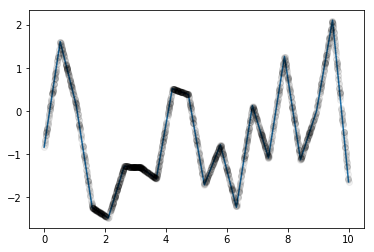

In [4]:
#Here's a test case to ensure it's working properly
x=np.random.rand(2000)*10
xdata=np.linspace(0,10,20)
ydata=np.random.rand(20)*5-2.5
interps=interpolate(x,xdata,ydata)
plt.plot(xdata,ydata)
plt.plot(x,interps,'ko',alpha=.05)
plt.show()

It works! We can proceed to the next exercise.

### Exercise 2

Using your "Numbafied" linear interpolation function, try to use Numba to additionally speed up the endogenous grid method code from [this lecture](https://lectures.quantecon.org/py/egm_policy_iter.html).  Use CRRA utility and Cobb-Douglas production, as in that lecture, with the following parameter values.


Note: I didn't get much speed up.  I think because the outer loops don't matter much for speed, and hence it doesn't gain us much when we compile them.  

See how you go.

In [5]:
def coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: np.interp(x, y, c)
    return Kg

def coleman_egm_numba(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks):
    """
    The approximate Coleman operator, updated using the endogenous grid
    method.  
    
    Parameters
    ----------
    g : function
        The current guess of the policy function
    k_grid : array_like(float, ndim=1)
        The set of *exogenous* grid points, for capital k = y - c
    beta : scalar
        The discount factor
    u_prime : function
        The derivative u'(c) of the utility function
    u_prime_inv : function
        The inverse of u' (which exists by assumption)
    f : function
        The production function f(k)
    f_prime : function
        The derivative f'(k)
    shocks : numpy array
        An array of draws from the shock, for Monte Carlo integration (to
        compute expectations).

    """

    # Allocate memory for value of consumption on endogenous grid points
    c = np.empty_like(k_grid)  

    # Solve for updated consumption value
    for i, k in enumerate(k_grid):
        vals = u_prime(g(f(k) * shocks)) * f_prime(k) * shocks
        c[i] = u_prime_inv(beta * np.mean(vals))
    
    # Determine endogenous grid
    y = k_grid + c  # y_i = k_i + c_i

    # Update policy function and return
    Kg = lambda x: interpolate(x, y, c)
    return Kg



alpha = 0.65
beta = 0.95
mu = 0
s = 0.1
grid_min = 1e-6
grid_max = 4
grid_size = 200
shock_size = 250

gamma = 1.5   # Preference parameter
gamma_inv = 1 / gamma

def f(k):
    return k**alpha

def f_prime(k):
    return alpha * k**(alpha - 1)

def u(c):
    return (c**(1 - gamma) - 1) / (1 - gamma)

def u_prime(c):
    return c**(-gamma)

def u_prime_inv(c):
    return c**(-gamma_inv)

k_grid = np.linspace(grid_min, grid_max, grid_size)
shocks = np.exp(mu + s * np.random.randn(shock_size))

## Let's make convenience functions based around these primitives

def crra_coleman_egm(g):
    return coleman_egm(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks)
def crra_coleman_egm_numba(g):
    return coleman_egm_numba(g, k_grid, beta, u_prime, u_prime_inv, f, f_prime, shocks)


sim_length = 20




We now run the speed test.

In [6]:
print("Timing policy function iteration with endogenous grid, numpy interpolation")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman_egm(g)
    g = new_g
qe.util.toc()


print("Timing policy function iteration with endogenous grid, numba interpolation")
g_init_egm = lambda x: x
g = g_init_egm
qe.util.tic()
for i in range(sim_length):
    new_g = crra_coleman_egm_numba(g)
    g = new_g
qe.util.toc()

Timing policy function iteration with endogenous grid, numpy interpolation
TOC: Elapsed: 0.15163064002990723 seconds.
Timing policy function iteration with endogenous grid, numba interpolation
TOC: Elapsed: 0.15625238418579102 seconds.


0.15625238418579102

My code was slightly slower than the numpy interpolation function. This shows that gains from jit compilation are offset by the loss of the efficiency built into the numpy interpolation function.